In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from scipy.stats import weibull_min
import matplotlib.mlab as mlab
import scipy.stats as ss
import math
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.special import gamma, factorial

In [3]:
df = pd.read_csv("q3.csv",index_col=0)

In [11]:
lengths = {'A':80,'B':90,'C':60,'D':126,'E':90}

# Find best-fit failure distributions

A
1159.6 1182.347142857143 508.1729322418357


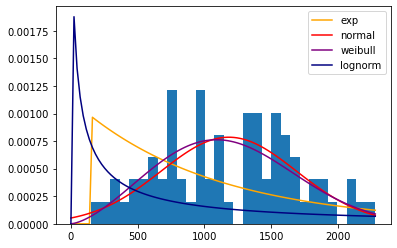

B
232.45 348.08690476190475 402.4948508336006


/Users/hellozhems/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2046: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


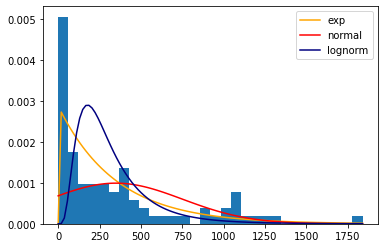

C
447.45 446.7766666666665 217.45955667408344


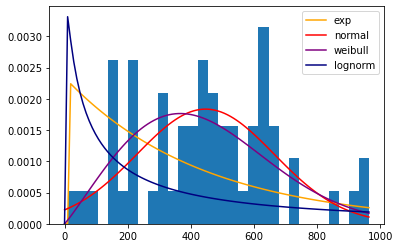

D
1184.7 1800.61746031746 1670.1909587657206


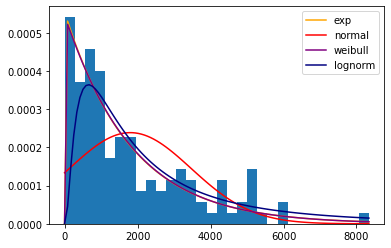

E
2081.2 2697.241772151898 2127.137768868946


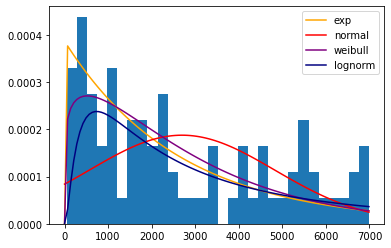

Repair Time
11.8 15.717021276631579 16.701513567073224


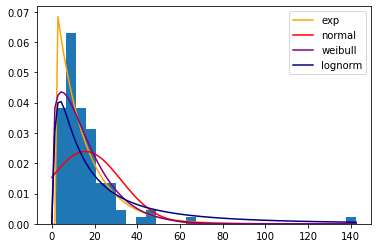

In [64]:
for col in df.columns:
    data = df[col].dropna().copy()
    print(col)
    median, mu, sigma = np.median(data),np.mean(data),np.std(data)
    print(median, mu, sigma)

    rX = np.linspace(0,max(data), 100)
    # exponential
    P = ss.expon.fit(data)
    rP = ss.expon.pdf(rX, *P)

    # normal
    normP = ss.norm.fit(data)
    normrP = ss.norm.pdf(rX, *normP)

    # Weibull
    weiP = ss.weibull_min.fit(data, floc=0)
    weirP = ss.weibull_min.pdf(rX, *weiP)

    # Weibull
    logP = ss.lognorm.fit(data)
    logrP = ss.lognorm.pdf(rX, *weiP)

    n,bins,cont = plt.hist(data, density=True, bins=30)  # density=False would make counts
    max_ratio = 6
    if max(rP)/max(n) <max_ratio:
        plt.plot(rX, rP, color ='orange',label='exp')
    if max(normrP)/max(n) <max_ratio:
        plt.plot(rX, normrP, color ='red',label='normal')
    if max(weirP)/max(n) <max_ratio:
        plt.plot(rX, weirP, color ='purple',label='weibull')
    if max(logrP)/max(n) <max_ratio:
        plt.plot(rX, logrP, color ='navy',label='lognorm')
    plt.legend(loc="upper right")
    plt.show()

In [137]:
best_fit = {'A':'w','B':'e','C':'w','D':'e','E':'w','Repair Time':'w'}
paras = {}
for i in df.columns:
    data = df[i].dropna().copy()
    print(i)
    if best_fit[i] == 'w':
        shape,loc,scale = ss.weibull_min.fit(data, floc=0)
        paras[i] = shape,scale
        print(shape,scale)
    elif best_fit[i] == 'e':
        loc, scale = ss.expon.fit(data)
        paras[i] = 1/scale
        print(scale)

A
2.517875275657132 1332.4332341044333
B
347.9869047619048
C
2.089338035932316 500.781212480881
D
1798.81746031746
E
1.1620315113324662 2836.105261943644
Repair Time
1.2412661365976316 17.058960233972957


# Compute Performance Measurements

$\beta$ is the first, $\theta$ is the second

In [138]:
paras

{'A': (2.517875275657132, 1332.4332341044333),
 'B': 0.00287367135462815,
 'C': (2.089338035932316, 500.781212480881),
 'D': 0.0005559207768772254,
 'E': (1.1620315113324662, 2836.105261943644),
 'Repair Time': (1.2412661365976316, 17.058960233972957)}

In [139]:
def R(t):
    return np.exp(-(t*(paras['B']+paras['D'])+sum([(t/paras[i][1])**paras[i][0] for i in ['A','C','E']])))

In [140]:
R(5)

0.9823124629123697

In [147]:
R(125)

0.5987569008055672

In [142]:
def R_(t):
    return np.exp(-(t*(paras['B']+paras['D'])+sum([(t/paras[i][1])**paras[i][0] for i in ['A','C','E']])))-0.5
fsolve(R_, [1])

array([162.41229796])

In [143]:
R(162.41229796)

0.4999999999996832

In [144]:
paras['Repair Time'][1]*gamma(1+1/paras['Repair Time'][0])

15.914133241640979

In [159]:
def wb(x):
    return 1-np.exp(-(x/paras['Repair Time'][1])**paras['Repair Time'][0])
def wb90(x):
    return 1-np.exp(-(x/paras['Repair Time'][1])**paras['Repair Time'][0])-0.9
fsolve(wb90,[1])

array([33.40135005])

In [146]:
wb(33.40135005)

0.8999999999825136

# Which subsystem displays the worst reliability?

In [148]:
R(50)

0.827774072533606

In [150]:
def R_imp(t):
    return np.exp(-(t*(paras['D'])+sum([(t/paras[i][1])**paras[i][0] for i in ['A','C','E']])))
R_imp(50)

0.9556806657659889

In [162]:
def R_solve(c):
    t = 50
    return np.exp(-(t*(1/c+paras['D'])+sum([(t/paras[i][1])**paras[i][0] for i in ['A','C','E']])))-0.9
fsolve(R_solve,[1])

array([832.92988569])

In [163]:
def R_imp(t):
    return np.exp(-(t*(paras['D']+1/832.92988569)+sum([(t/paras[i][1])**paras[i][0] for i in ['A','C','E']])))
R_imp(50)

0.9000000000000954

In [165]:
np.exp(-50/fsolve(R_solve,[1])[0])

0.9417371641380229